In [1]:
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from tifffile import imread, imsave, imwrite
import math
from PIL import Image
import os, shutil
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate
from skimage import io
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tifffile import imread
import math
import xlwt
from xlwt import Workbook
from torch.nn import ReflectionPad3d
import torch
from matplotlib.pyplot import imshow
from keras.callbacks import ModelCheckpoint
from focal_loss import BinaryFocalLoss
import torch
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
from keras.layers.merge import Concatenate

# Prepare Train, Validation and Test Set

In [10]:
def patchify_rgb(image, patch_size=(64,64,32), step=32):
    
    img_patches_R = patchify(image[:,:,:,0], patch_size, step=step)
    input_img_R = np.reshape(img_patches_R, (-1, img_patches_R.shape[3], img_patches_R.shape[4], img_patches_R.shape[5]))

    img_patches_G = patchify(image[:,:,:,1], patch_size, step=step) 
    input_img_G = np.reshape(img_patches_G, (-1, img_patches_G.shape[3], img_patches_G.shape[4], img_patches_G.shape[5]))
    
    if image.shape[3] == 3:
      img_patches_B = patchify(image[:,:,:,2], patch_size, step=step)
      input_img_B = np.reshape(img_patches_B, (-1, img_patches_B.shape[3], img_patches_B.shape[4], img_patches_B.shape[5]))
      img_patches_rgb = np.stack((input_img_R,input_img_G,input_img_B), axis=-1)
    else:
      img_patches_rgb = np.stack((input_img_R,input_img_G), axis=-1)
    
    return img_patches_rgb

In [11]:
def rgb_to_label(mask):
      
    label_mask = np.stack((mask[:,:,:,0],mask[:,:,:,1]), axis=-1)
    
    return label_mask

In [12]:
def padding(image,size):

    img_reshape = np.moveaxis(image, -1, 0)
    
    m = ReflectionPad3d((0,size[2]-image.shape[2],0,size[1]-image.shape[1],0,size[0]-image.shape[0]))
    input = torch.tensor(img_reshape, dtype=torch.float)
    output = m(input)
    pad_img = output.numpy()
    pad_img = np.moveaxis(pad_img, 0, -1)
    
    return pad_img

In [13]:
def dir_setup(patches_dir):
  
  
  train_dir = os.path.join(patches_dir, 'Train')
  if os.path.exists(train_dir)==False:
        os.mkdir(train_dir)

  train_dir_img = os.path.join(train_dir, 'Images')
  if os.path.exists(train_dir_img)==False:
        os.mkdir(train_dir_img)

  train_dir_mask = os.path.join(train_dir, 'Masks')
  if os.path.exists(train_dir_mask)==False:
        os.mkdir(train_dir_mask)

  val_dir = os.path.join(patches_dir, 'Validation')
  if os.path.exists(val_dir)==False:
        os.mkdir(val_dir)

  val_dir_img = os.path.join(val_dir, 'Images')
  if os.path.exists(val_dir_img)==False:
        os.mkdir(val_dir_img)

  val_dir_mask = os.path.join(val_dir, 'Masks')
  if os.path.exists(val_dir_mask)==False:
        os.mkdir(val_dir_mask)

  tst_dir = os.path.join(patches_dir, 'Test')
  if os.path.exists(tst_dir)==False:
        os.mkdir(tst_dir)

  tst_dir_img = os.path.join(tst_dir, 'Images')
  if os.path.exists(tst_dir_img)==False:
        os.mkdir(tst_dir_img)

  tst_dir_mask = os.path.join(tst_dir, 'Masks')
  if os.path.exists(tst_dir_mask)==False:
        os.mkdir(tst_dir_mask)

  return [train_dir_img, train_dir_mask, val_dir_img, val_dir_mask, tst_dir_img, tst_dir_mask]

In [14]:
def train_validation_test_setup(img_dir, mask_dir, patches_dir):

  img_name = os.listdir(img_dir)

  #train, validate, test = np.split(img_name, [int(len(img_name)*0.6), int(len(img_name)*0.8)])
  train = ["Crop1.tif", "Crop2.tif", "Crop3.tif", "Crop8_BC.tif"]
  validate = ["Crop4.tif", "Crop6_BC.tif"]
  test = ["Crop5_BC.tif", "Crop7_BC.tif"]

  n_train = len(train)
  n_validation = len(validate)
  n_test = len(test)

  [train_dir_img, train_dir_mask, val_dir_img, val_dir_mask, tst_dir_img, tst_dir_mask] = dir_setup(patches_dir)

  for i in range(n_train):
    image = imread(img_dir + train[i])
    mask = imread(mask_dir + train[i])

    image = padding(image, (image.shape[0], image.shape[1], 64, image.shape[3]))
    mask = padding(mask, (mask.shape[0], mask.shape[1], 64, mask.shape[3]))

    # normalize data
    nor_image = image / 255.
    nor_mask = mask / 255.

    # labeling data
    #label_mask = rgb_to_label(nor_mask)

    img_patches = patchify_rgb(nor_image,(64,64,64),48)
    mask_patches = patchify_rgb(nor_mask,(64,64,64),48)

    for p in range(img_patches.shape[0]):
      imwrite(train_dir_img + '/img_patch_' + str(i+1) + str(p) + '.tif', img_patches[p,:,:,:])

    for k in range(mask_patches.shape[0]):
      imwrite(train_dir_mask + '/img_patch_' + str(i+1) + str(k) + '.tif', mask_patches[k,:,:,:])


  for j in range(n_validation):
    image = imread(img_dir + validate[j])
    mask = imread(mask_dir + validate[j])

    image = padding(image, (image.shape[0], image.shape[1], 64, image.shape[3]))
    mask = padding(mask, (mask.shape[0], mask.shape[1], 64, mask.shape[3]))

    # normalize data
    nor_image = image / 255.
    nor_mask = mask / 255.

    # labeling data
    #label_mask = rgb_to_label(nor_mask)

    img_patches = patchify_rgb(nor_image,(64,64,64),48)
    mask_patches = patchify_rgb(nor_mask,(64,64,64),48)

    for p in range(img_patches.shape[0]):
      imwrite(val_dir_img + '/img_patch_' + str(j+1) + str(p) + '.tif', img_patches[p,:,:,:])

    for k in range(mask_patches.shape[0]):
      imwrite(val_dir_mask + '/img_patch_' + str(j+1) + str(k) + '.tif', mask_patches[k,:,:,:])


  for fname in test:
    src_img = os.path.join(img_dir, fname)
    dst_img = os.path.join(tst_dir_img, fname)
    shutil.copyfile(src_img, dst_img)

    src_mask = os.path.join(mask_dir, fname)
    dst_mask = os.path.join(tst_dir_mask, fname)
    shutil.copyfile(src_mask, dst_mask)
    




In [15]:
img_dir = './Dataset_3/Images_Pre/'
mask_dir = './Dataset_3/Masks/'
patches_dir = './Dataset_3/Patches_64/'
train_validation_test_setup(img_dir, mask_dir, patches_dir)

(64, 64, 64, 3)


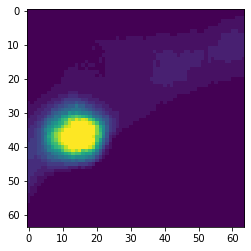

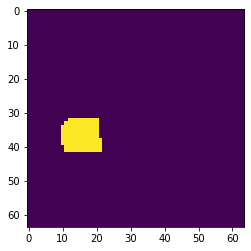

In [16]:
a = imread('./Dataset_3/Patches_64/Train/Images/img_patch_4107.tif')
plt.figure(1)
imshow(a[:,:,30,0])
plt.figure(2)
b = imread('./Dataset_3/Patches_64/Train/Masks/img_patch_4107.tif')
imshow(b[:,:,30,0])
print(b.shape)

#a = a*255.0
#a = a.astype('uint8')

#imwrite('./Dataset/' + 'img_patch.tif' , a, photometric='rgb')

#_b = _b*255.0
#_b = _b.astype('uint8')

#imwrite('./Dataset/' + 'mask_patch.tif' , _b, photometric='rgb')


# Train Model

In [2]:
import sys  
sys.path.insert(0, './')

In [3]:
import data_generator_3
from data_generator_3 import DataGenerator

In [4]:
def conv_block(inputs, num_filters):
    x = Conv3D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)    
    x = Activation("relu")(x)

    x = Conv3D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPooling3D((2, 2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(inputs, skip_features, num_filters):
    x = Conv3DTranspose(num_filters, (2, 2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [5]:
#Build Unet using the blocks
def build_unet(input_shape, n_classes, n_filters_start=32, growth_factor=2):
    inputs = Input(input_shape)
    n_filters = n_filters_start
    
    s1, p1 = encoder_block(inputs, n_filters)
    n_filters *= growth_factor
    
    s2, p2 = encoder_block(p1, n_filters)
    n_filters *= growth_factor
    
    s3, p3 = encoder_block(p2, n_filters)
    n_filters *= growth_factor
    
    s4, p4 = encoder_block(p3, n_filters)
    n_filters *= growth_factor

    b1 = conv_block(p4, n_filters) #Bridge
    
    n_filters //= growth_factor
    d1 = decoder_block(b1, s4, n_filters)
    
    n_filters //= growth_factor
    d2 = decoder_block(d1, s3, n_filters)
    
    n_filters //= growth_factor
    d3 = decoder_block(d2, s2, n_filters)
    
    n_filters //= growth_factor
    d4 = decoder_block(d3, s1, n_filters)

    outputs = Conv3D(n_classes, 1, padding="same", activation='sigmoid')(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model

In [6]:
# Loss Function and coefficients to be used during training:
def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + smoothing_factor)

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [9]:
def model_plots(history, plot_dir):
  #plot the training and validation IoU and loss at each epoch
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(loss) + 1)

  plt.figure(1)
  plt.plot(epochs, loss, 'y', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig(plot_dir + '/loss_plot_3.png')

  acc = history.history['dice_coefficient']
  val_acc = history.history['val_dice_coefficient']

  plt.figure(2)
  plt.plot(epochs, acc, 'y', label='Training Dice')
  plt.plot(epochs, val_acc, 'r', label='Validation Dice')
  plt.title('Training and validation Dice')
  plt.xlabel('Epochs')
  plt.ylabel('Dice')
  plt.legend()
  plt.savefig(plot_dir + '/dice_plot_3.png')

In [8]:
batch_size = 4

traingen = DataGenerator('Train', batch_size=batch_size, img_size=(64,64,64,3), mask_size=(64,64,64,3))

valgen = DataGenerator('Validation', batch_size=batch_size, img_size=(64,64,64,3), mask_size=(64,64,64,3))

#Define parameters for our model.

patch_size = (64,64,64,3)

LR = 0.0001
optim = Adam(LR,amsgrad=True)

model = build_unet(patch_size, n_classes=3)

#for layer in model.layers:
#    print(layer.output_shape)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer = optim, loss=dice_coefficient_loss, metrics=dice_coefficient)

checkpoint = ModelCheckpoint('./Models_UNET')

#Fit the model
history = model.fit(traingen,
         validation_data=valgen,
         epochs=100, verbose=1, callbacks=[early_stopping, checkpoint])

2022-10-10 16:10:04.257529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 16:10:04.272990: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 16:10:04.273352: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 16:10:04.274257: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/100


2022-10-10 16:10:07.381214: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8101
2022-10-10 16:10:07.563753: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-10 16:10:07.564135: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-10 16:10:07.564157: W tensorflow/stream_executor/gpu/asm_compiler.cc:77] Couldn't get ptxas version string: Internal: Couldn't invoke ptxas --version
2022-10-10 16:10:07.564520: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-10-10 16:10:07.564566: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


131/131 [==============================] - 102s 747ms/step - loss: 2.6951 - dice_coefficient: 0.1015 - val_loss: 2.8557 - val_dice_coefficient: 0.0436


2022-10-10 16:11:50.463853: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./Models_UNET/assets
Epoch 2/100
131/131 [==============================] - 99s 756ms/step - loss: 2.6051 - dice_coefficient: 0.1177 - val_loss: 2.6358 - val_dice_coefficient: 0.1027
INFO:tensorflow:Assets written to: ./Models_UNET/assets
Epoch 3/100
131/131 [==============================] - 104s 791ms/step - loss: 2.5686 - dice_coefficient: 0.1240 - val_loss: 2.6091 - val_dice_coefficient: 0.1112
INFO:tensorflow:Assets written to: ./Models_UNET/assets
Epoch 4/100
131/131 [==============================] - 105s 804ms/step - loss: 2.5326 - dice_coefficient: 0.1320 - val_loss: 2.6416 - val_dice_coefficient: 0.0988
INFO:tensorflow:Assets written to: ./Models_UNET/assets
Epoch 5/100
131/131 [==============================] - 105s 806ms/step - loss: 2.4906 - dice_coefficient: 0.1414 - val_loss: 2.5649 - val_dice_coefficient: 0.1178
INFO:tensorflow:Assets written to: ./Models_UNET/assets
Epoch 6/100
131/131 [==============================] - 105s 806ms/ste

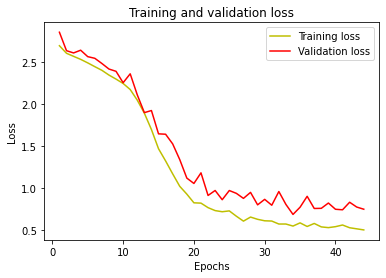

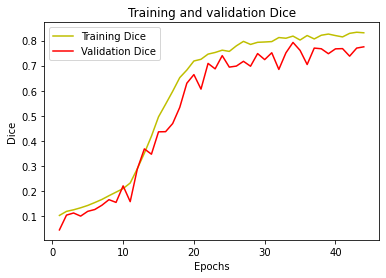

In [10]:
plot_dir = './Dataset_3/Model_Plots'
#os.mkdir(plot_dir)

model_plots(history, plot_dir)

model.save('./Models_UNET/UNET_3D_Final_3channel_1.h5')

# Test Model

In [11]:
def padding(image,size):

    img_reshape = np.moveaxis(image, -1, 0)
    
    m = ReflectionPad3d((0,size[2]-image.shape[2],0,size[1]-image.shape[1],0,size[0]-image.shape[0]))
    input = torch.tensor(img_reshape, dtype=torch.float)
    output = m(input)
    pad_img = output.numpy()
    pad_img = np.moveaxis(pad_img, 0, -1)
    
    return pad_img

In [12]:
def thresholding(patch_prediction):
    patch_ind_nuclei = np.argwhere(patch_prediction[:,:,:,0] > 0.5)
    patch_ind_golgi = np.argwhere(patch_prediction[:,:,:,1] > 0.5)
    patch_ind_int = np.argwhere(patch_prediction[:,:,:,2] > 0.5)

    patch_prediction_thr = np.zeros((patch_prediction.shape[0],patch_prediction.shape[1],patch_prediction.shape[2],3))

    for i in range(patch_ind_nuclei.shape[0]):
        patch_prediction_thr[patch_ind_nuclei[i,0],patch_ind_nuclei[i,1],patch_ind_nuclei[i,2],0]=1 

    for j in range(patch_ind_golgi.shape[0]):
        patch_prediction_thr[patch_ind_golgi[j,0],patch_ind_golgi[j,1],patch_ind_golgi[j,2],1]=1
    
    for k in range(patch_ind_int.shape[0]):
        patch_prediction_thr[patch_ind_int[k,0],patch_ind_int[k,1],patch_ind_int[k,2],2]=1

    return patch_prediction_thr

In [13]:
def pred_mask(image, mask_shape):
  patch_size = 64
  step = 48

  pred_mask = np.zeros(((image.shape[0] // step)*step + patch_size,(image.shape[1] // step)*step + patch_size,64,3))
  _image = padding(image, ((image.shape[0] // step)*step + patch_size,(image.shape[1] // step)*step + patch_size,64,3))

  i = 0
  while i + patch_size <= _image.shape[0]:
    j = 0
    while j + patch_size <= _image.shape[1]:

        tst_patch = _image[i:i+patch_size, j:j+patch_size, :, :]
        tst_patch = np.array([tst_patch / 255.])
        preds_tst = my_model.predict(tst_patch)
        pred_patch = preds_tst[0,:,:,:,:]
        pred_patch_thr = thresholding(pred_patch)

        pred_mask[i:i+patch_size, j:j+patch_size,:,0] = np.array(np.logical_or(pred_mask[i:i+patch_size, j:j+patch_size, :,0], pred_patch_thr[:,:,:,0], dtype = 'float32'))
        pred_mask[i:i+patch_size, j:j+patch_size,:,1] = np.array(np.logical_or(pred_mask[i:i+patch_size, j:j+patch_size, :,1], pred_patch_thr[:,:,:,1], dtype = 'float32'))
        pred_mask[i:i+patch_size, j:j+patch_size,:,2] = np.array(np.logical_or(pred_mask[i:i+patch_size, j:j+patch_size, :,2], pred_patch_thr[:,:,:,2], dtype = 'float32'))

        j += step
        
    i += step
    
  _pred_mask = np.zeros(mask_shape)
  _pred_mask = pred_mask[0:mask_shape[0],0:mask_shape[1],0:mask_shape[2],:]

  return _pred_mask, _image


In [14]:
def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + smoothing_factor)

def precision(y_true, y_pred):
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return(K.sum(flat_y_true * flat_y_pred) / K.sum(flat_y_pred) )

def recall(y_true, y_pred):
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return(K.sum(flat_y_true * flat_y_pred) / K.sum(flat_y_true) )

In [15]:
def metrics(mask, _pred_mask):
  _mask = mask/255.

  dice_coef_int = dice_coefficient(_mask[:,:,:,2],_pred_mask[:,:,:,2])
  dice_coef_nuclei = dice_coefficient(_mask[:,:,:,1],_pred_mask[:,:,:,1])
  dice_coef_golgi = dice_coefficient(_mask[:,:,:,0],_pred_mask[:,:,:,0])
  prec_int = precision(_mask[:,:,:,2],_pred_mask[:,:,:,2])
  prec_nuclei = precision(_mask[:,:,:,1],_pred_mask[:,:,:,1])
  prec_golgi = precision(_mask[:,:,:,0],_pred_mask[:,:,:,0])
  recall_int = recall(_mask[:,:,:,2],_pred_mask[:,:,:,2])
  recall_nuclei = recall(_mask[:,:,:,1],_pred_mask[:,:,:,1])
  recall_golgi = recall(_mask[:,:,:,0],_pred_mask[:,:,:,0])

  return [round(dice_coef_nuclei.numpy(),4), round(dice_coef_golgi.numpy(),4),round(dice_coef_int.numpy(),4), 
          round(prec_nuclei.numpy(),4), round(prec_golgi.numpy(),4),round(prec_int.numpy(),4), round(recall_nuclei.numpy(),4),
          round(recall_golgi.numpy(),4), round(recall_int.numpy(),4)]


In [16]:
def write_to_excel(wb,sheet_name,metrics, result_dir):

  # add_sheet is used to create sheet.
  sheet1 = wb.add_sheet(sheet_name)

  sheet1.write(0, 0, 'Dice Coeffient Nuclei')
  sheet1.write(0, 1, 'Dice Coeffient Golgi')
  sheet1.write(0, 2, 'Dice Coeffient Intersection')
  sheet1.write(0, 3, 'Precision Nuclei')
  sheet1.write(0, 4, 'Precision Golgi')
  sheet1.write(0, 5, 'Precision Intersection')
  sheet1.write(0, 6, 'Recall Nuclei')
  sheet1.write(0, 7, 'Recall Golgi')
  sheet1.write(0, 8, 'Recall Intersection')
  sheet1.write(1, 0, metrics[0])
  sheet1.write(1, 1, metrics[1])
  sheet1.write(1, 2, metrics[2])
  sheet1.write(1, 3, metrics[3])
  sheet1.write(1, 4, metrics[4])
  sheet1.write(1, 5, metrics[5])
  sheet1.write(1, 6, metrics[6])
  sheet1.write(1, 7, metrics[7])
  sheet1.write(1, 8, metrics[8])

  wb.save(result_dir + '/results_metrics.xlsx')


In [17]:
def test_model(base_dir):

  fnames = os.listdir(base_dir + 'Images/')

  # Workbook is created
  wb = Workbook()

  result_dir = './Dataset_3/Results_UNET'
  if os.path.exists(result_dir)==False:
        os.mkdir(result_dir)

  for i in range(len(fnames)):

    image = imread(base_dir + 'Images/' + fnames[i])
    mask = imread(base_dir + 'Masks/' + fnames[i])

    predicted_mask, img_tst = pred_mask(image, image.shape)

    _predicted_mask = predicted_mask*255.0
    _predicted_mask = _predicted_mask.astype('uint8')

    imwrite(result_dir + '/pred_mask_' + fnames[i] , _predicted_mask, photometric='rgb')

    _metrics = metrics(mask, predicted_mask)

    write_to_excel(wb,'Sheet_' + fnames[i].split('.')[0], _metrics, result_dir)
    
  return img_tst

In [18]:
#Load the pretrained model for testing and predictions. 
from keras.models import load_model
my_model = load_model('./Models_UNET/UNET_3D_Final_3channel_1.h5', compile=False)
#If you load a different model do not forget to preprocess accordingly. 

base_dir = './Dataset_3/Patches_64/Test/'

img_tst = test_model(base_dir)